## Initial Imports

In [24]:
import matplotlib.pyplot as plt
import numpy as np

## Time

In [25]:
t_final = 30
dtAccel = 0.005  # TODO: assumption that the time interval is constant 
t_step = np.arange(dtAccel,t_final,dtAccel)
print(len(t_step))
print(t_step)

5999
[5.0000e-03 1.0000e-02 1.5000e-02 ... 2.9985e+01 2.9990e+01 2.9995e+01]


## Generating True Accelerometer 

In [26]:
true_accel = np.concatenate(([0],np.random.random_sample((len(t_step),))*10))
print(true_accel)
print(len(true_accel))

[0.         4.09878202 1.19121639 ... 0.67156419 3.59291443 0.50856121]
6000


## Generating True Velocity and Position

In [27]:
#a priori statistics => x ~ N(0,10^2), v ~ N(100,1^2)
pos_0 = 0 # meters
vel_0 = 100 # meters/second 


true_vel = [vel_0]
true_pos = [pos_0]

for i in range(len(t_step)):
    if i == 0:
        p_last = pos_0
        v_last = vel_0
        
    v_current = v_last + (true_accel[i]*dtAccel)
    true_vel.append(v_current)
    v_last = v_current
    
    p_current = p_last + v_last*dtAccel + true_accel[i]*(dtAccel**2)/2
    true_pos.append(p_current)
    p_last = p_current
    
print("acceleration")
print(len(true_accel))
print(true_accel[0:10])

print("velocity")


print(len(true_vel))
print(true_vel[0:10])

print("position")

print(len(true_pos))
print(true_pos[0:10])

acceleration
6000
[0.         4.09878202 1.19121639 2.688463   2.92633672 8.7204108
 8.41020276 6.89642579 5.20525237 8.74401739]
velocity
6000
[100, 100.0, 100.02049391011806, 100.02644999206237, 100.03989230708096, 100.05452399070434, 100.0981260446951, 100.14017705851417, 100.17465918745344, 100.20068544930434]
position
6000
[0, 0.5, 1.0001537043258857, 1.5003008444910582, 2.0005339118140095, 2.50084311097659, 3.0014427463350426, 3.5022487591621614, 4.0032082604217765, 4.504276753322925]


## Generating Accelerometer, Velocity, and Position with bias and white gaussian noise 

In [28]:
# white gaussian noise with zero mean and variance = 0.0004
wV_Accel = .0004 # Accelerometer white noise variance 
wm_Accel = 0 # Accelerometer white noise mean
wN_Accel = np.array([wm_Accel, wV_Accel])

# bias with a priori statistics b_a ~ N(0,0.01)
bu_Accel = 0 # Mean of bias term
bV_Accel = .01 # Variance of bias (m/s^2)^2
bN_Accel = np.array([bu_Accel, bV_Accel])

print("white gaussian noise of accelerometer : ", wN_Accel)
print("bias of accelerometer: ",bN_Accel)


def get_white_noise_accelerometer():
    return np.asscalar(np.random.normal(wN_Accel[0],np.sqrt(wN_Accel[1]),1))

def set_bias_accelerometer():
    return np.asscalar(np.random.normal(bN_Accel[0], np.sqrt(bN_Accel[1]),1))

# a = a + w + b
def get_accelerometer_reading(i, white_noise):
    return true_accel[i] + white_noise + bu_Accel

# Takes in last state @ time = k, calculates the new acceleration state @ time = k+1
def get_pos_vel_from_accel(ilast,xlast,white_noise):
    # v_new = a_last*dt + v_last
    vAc = get_accelerometer_reading(ilast,white_noise)*dtAccel + np.asscalar(xlast[1])
    # x_new = p_last + v_last*dt + a_last*dt^2/2
    xAc = (get_accelerometer_reading(ilast, white_noise)*dtAccel**2)/2 + np.asscalar(xlast[1])*dtAccel + np.asscalar(xlast[0])
    bias = np.asscalar(xlast[2])
    return np.matrix([xAc,vAc,bias]).transpose() 

white gaussian noise of accelerometer :  [0.     0.0004]
bias of accelerometer:  [0.   0.01]


## Generating GPS with Noise

In [29]:
# Functions, Variances, Means, and equations for the GPS states: Position and Velocity
dtGPS = dtAccel*40 # seconds

wmp_GPS = 0 # meters, mean of the white noise measurement of position
wmv_GPS = 0 # meters / second, mean of the white noise measurement of velocity
wVp_GPS = 1 # meter^2, variance of the white noise measurement of position
wVv_GPS = .04**2 # (4cm/s)**2 = .04**2 (m/s)^2, varaince of the white noise measurement of velocity

wNp_GPS = np.array([wmp_GPS,wVp_GPS])
wNv_GPS = np.array([wmv_GPS,wVv_GPS])


# returns the GPS noise for a given timestep
def get_measurement_noise_GPS():
    wp = np.asscalar(np.random.normal(wNp_GPS[0],np.sqrt(wNp_GPS[1]),1))
    wv = np.asscalar(np.random.normal(wNv_GPS[0],np.sqrt(wNv_GPS[1]),1))
    wb = 0 # This the the extra zero padding, corresponding to the last term (bias) of the state dynamics
    return np.matrix([wp,wv,wb]).transpose()

# [ p + n_p ]
# [ v + n_p ]
# [ 0 + bias ]
# returns the current GPS measurement vector for the system
def get_measurement_GPS(i):
    return np.matrix([true_pos[i], true_vel[i],0]).transpose() + get_measurement_noise_GPS()

In [30]:
F = np.matrix([[1, dtAccel, -dtAccel/2],
               [0,    1,      -dtAccel],
               [0,    0,       1     ]])
    
B = np.matrix([dtAccel**2/2,dtAccel, 0]).transpose()

# pass in the current time, position and velocity readings for the expected 
def state_dynamics(dx_prev, w_prev):
    dx_new = F*dx_prev - B*w_prev
    return dx_new

In [31]:
H = np.matrix(np.eye(3)) # H Matrix
I = np.matrix(np.eye(3)) # I Matrix

In [32]:
# We are given an initial state x0
# the initial state is taken as the expected state minus the accelerometer's state reading
x0 = np.matrix([pos_0,vel_0,0]).transpose() # the initial assumed 
x0c = np.matrix([pos_0,vel_0,set_bias_accelerometer()]).transpose() # The initial accelerometer reading 
dx0 = x0 - x0c # initial state of kalman dynamics

#a priori statistics => x ~ N(0,10^2), v ~ N(100,1^2)
# bias with a priori statistics b_a ~ N(0,0.01)
P0 = np.matrix([[100,0,0],
               [0,1,0],
               [0,0,.01]]) # This is the initial process covariance matrix 
#Measurement covariance matrix 
R = np.matrix([[1,0,0],
               [0,.0016,0],
               [0,0,.01]]) # This is the measurement covariance matrix

# W = wV_Accel # .0004
Q = B*wV_Accel*B.getT() # This is the process noise covariance matrix

In [33]:
# Keep all information for plotting
True_Accel = []
True_Vel = []
True_Pos = []
Kalman_Estimate_Pos = []
Kalman_Estimate_Vel = []
Accelerometer_Pos = []
Accelerometer_Vel = []
Accelerometer_Acc = []
dztt = []
GPS_Pos = []
GPS_Vel = []
Kalman_State_Pos = []
Kalman_State_Vel = []
Kalman_State_Bias = []
Error_Priori=[]
Error_Posteriori=[]
Error_Ensemble=[]
Monte_dx=[]

# t_final = 30 # seconds
# t_step = np.arange(dtAccel,t_final,dtAccel) # Time steps [.005  30] seconds
# print(t_step)

In [34]:
# Initialize Looping variables
dx_hat_current = dx0 # @ t = 0 seconds, The current state estimate from the kalman filter
dx_hat_prev = 0 # the previous state estimate from the Kalman filter
PCM_current = P0 # @ t = 0 seconds, The current Process covariance matrix
PCM_prev = 0 # The previous process covariance matrix
accelerometer_reading_current = get_accelerometer_reading(0,get_white_noise_accelerometer()) # initial accelerometer reading

x_accel_current = x0
x_accel_prev = 0
w_current = get_white_noise_accelerometer()
w_prev = 0
biasTrue = set_bias_accelerometer()
x_true = np.matrix([true_pos[0], true_vel[0], biasTrue]).transpose()

dx_monte = x_true - x0c # for the check
counter = 40 # When counter reaches 40, we will take in GPS measurement reading, proceed with kalman filtering, then reset counter
steps = 151 # steps for update

In [35]:
# Save initial state information
True_Accel.append(true_accel[0])
True_Vel.append(true_vel[0])
True_Pos.append(true_pos[0])
Accelerometer_Pos.append(np.asscalar(x_accel_current[0])) # save the calculated accelerometer position reading for current time step
Accelerometer_Vel.append(np.asscalar(x_accel_current[1])) # save the calculated accelerometer veocity reading
Accelerometer_Acc.append(np.asscalar(accelerometer_reading_current))
GPS_Pos.append(np.asscalar(x_accel_current[0]))
GPS_Vel.append(np.asscalar(x_accel_current[1]))
Kalman_State_Pos.append(np.asscalar(dx_hat_current[0]))
Kalman_State_Vel.append(np.asscalar(dx_hat_current[1]))
Kalman_State_Bias.append(np.asscalar(dx_hat_current[2]))
Kalman_Estimate_Pos.append(np.asscalar(dx_hat_current[0]) + np.asscalar(x_accel_current[0]))
Kalman_Estimate_Vel.append(np.asscalar(dx_hat_current[1]) + np.asscalar(x_accel_current[1]))
Monte_dx.append(dx_monte)
Error_Priori.append(dx_monte - dx_hat_current)
Error_Posteriori.append(dx_monte - dx_hat_current)
dztt.append(dx0)


In [36]:
tlast = 1 # initial time
for t in range(len(t_step)):
    t = t+1
    
    # If we have hit 40 timesteps, 40* dtAccel = dtGPS, ready to do kalman update
    if counter == 40:
        
        counter = 0
        
        
        # 1) Current Becomes Previous t -> t-1
        dx_hat_prev = dx_hat_current
        PCM_prev = PCM_current
        x_accel_prev = x_accel_current
        w_prev = w_current 
        
        # 2) Model Dynamics: Find models estimate of dx and process error matrix
        w_current = get_white_noise_accelerometer() # get noise measurement for timestep t-1
        W = w_prev**2
        dx_bar = state_dynamics(dx_hat_prev, w_prev)
        #Q = G*W*G.getT()
        P_bar = F*PCM_prev*F.getT() + Q
        
        # 3) Calculate the Kalman gain 
        temp = H*P_bar*H.getT() + R
        Kt = P_bar*H.getT()*temp.getI()
        
        # 4) Using the kalman gain and a new measurement calculate the best state estimate dx_hat_current
        zt = get_measurement_GPS(t)
        accelerometer_reading_current = get_accelerometer_reading(t,get_white_noise_accelerometer())
        x_accel_current = get_pos_vel_from_accel(tlast,x_accel_prev,w_prev)
        dzt = zt - x_accel_current
        # Compute the best estimate
        dx_hat_current = dx_bar + Kt*(dzt - H*dx_bar)
        
        # 5) Update the process covariance matrix 
        PCM_current = (I - Kt*H)*P_bar
        
        # Save all of the current information that has elapsed in the all_state_info dictionary
        True_Accel.append(true_accel[t])
        True_Vel.append(true_vel[t])
        True_Pos.append(true_pos[t])
        Accelerometer_Pos.append(np.asscalar(x_accel_current[0])) # save the calculated accelerometer position reading for current time step
        Accelerometer_Vel.append(np.asscalar(x_accel_current[1])) # save the calculated accelerometer veocity reading
        Accelerometer_Acc.append(accelerometer_reading_current)
        GPS_Pos.append(np.asscalar(zt[0]))
        GPS_Vel.append(np.asscalar(zt[1]))
        Kalman_State_Pos.append(np.asscalar(dx_hat_current[0]))
        Kalman_State_Vel.append(np.asscalar(dx_hat_current[1]))
        Kalman_State_Bias.append(np.asscalar(dx_hat_current[2]))
        Kalman_Estimate_Pos.append(np.asscalar(dx_hat_current[0]) + np.asscalar(x_accel_current[0]))
        Kalman_Estimate_Vel.append(np.asscalar(dx_hat_current[1]) + np.asscalar(x_accel_current[1]))
        dztt.append(dzt)
        
        # Monte
        x_true = np.matrix([true_pos[t],true_vel[t],biasTrue]).transpose()
        dx_monte = x_true - x_accel_current
        Monte_dx.append(dx_monte)
        Error_Priori.append(dx_monte - dx_bar)
        Error_Posteriori.append(dx_monte - dx_hat_current)
        
        
    # Simply progogate the accleration forwards until the counter climbs back to 40
    else:
        # store previous accel and get current values 
        x_accel_prev = x_accel_current
        white_noise = get_white_noise_accelerometer()
        x_accel_current = get_pos_vel_from_accel(tlast,x_accel_prev,white_noise)
        True_Accel.append(true_accel[t])
        True_Vel.append(true_vel[t])
        True_Pos.append(true_pos[t])
        Accelerometer_Pos.append(np.asscalar(x_accel_current[0])) # save the calculated accelerometer position reading for current time step
        Accelerometer_Vel.append(np.asscalar(x_accel_current[1])) # save the calculated accelerometer veocity reading
        Accelerometer_Acc.append(get_accelerometer_reading(t,get_white_noise_accelerometer()))
        
        
    counter += 1
    tlast = t

In [37]:
print(len(true_accel))
print(true_accel[0:10])
print(true_accel[-2:])
print(len(True_Accel))
print(True_Accel[0:10])
print(True_Accel[-2:])


6000
[0.         4.09878202 1.19121639 2.688463   2.92633672 8.7204108
 8.41020276 6.89642579 5.20525237 8.74401739]
[3.59291443 0.50856121]
6000
[0.0, 4.098782023612637, 1.1912163888620952, 2.688463003717988, 2.9263367246747043, 8.72041079815239, 8.410202763811633, 6.896425787853503, 5.205252370181138, 8.744017393919602]
[3.592914429949201, 0.5085612143432272]


In [38]:
k = np.abs(np.array(Accelerometer_Acc) - np.array(True_Accel))

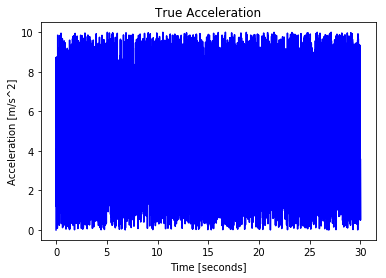

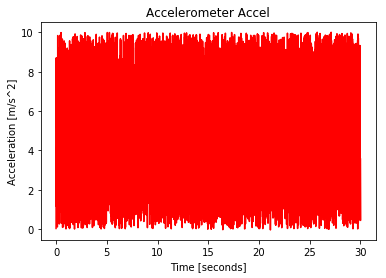

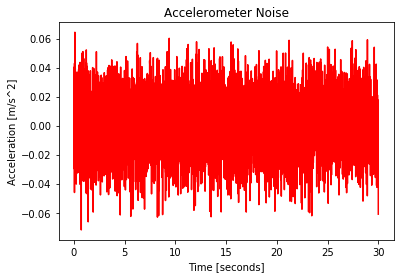

In [39]:
t1 = np.arange(0,30,dtAccel)
t2 = np.arange(0,30.2,.2)
plt.figure(1)
plt.title('True Acceleration')
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [seconds]')
plt.plot(t1,True_Accel,'b')

plt.figure(2)
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [seconds]')
plt.title('Accelerometer Accel')
plt.plot(t1,Accelerometer_Acc,'r')

plt.figure(3)
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [seconds]')
plt.title('Accelerometer Noise')
k = np.array(Accelerometer_Acc) - np.array(True_Accel)
plt.plot(t1,k,'r')


In [40]:
print(True_Vel[0:10])
print(Accelerometer_Vel[0:10])

[100, 100.0, 100.02049391011806, 100.02644999206237, 100.03989230708096, 100.05452399070434, 100.0981260446951, 100.14017705851417, 100.17465918745344, 100.20068544930434]
[100, 100.02055186983904, 100.04101233211158, 100.04715207013827, 100.06060174663453, 100.07514760040512, 100.11875107627876, 100.16073670593437, 100.19507781550944, 100.22112928677582]


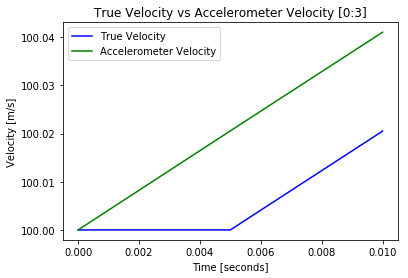

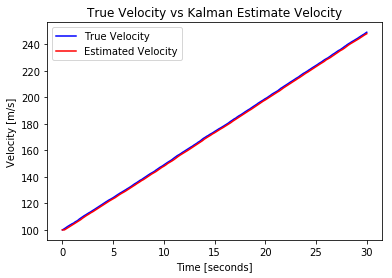

In [41]:
plt.figure(4)
# plt.figure(figsize=(20,10))
plt.title('True Velocity vs Accelerometer Velocity [0:3]')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Time [seconds]')
l = 3
tv, = plt.plot(t1[0:l],True_Vel[0:l],'b', label = 'True Velocity')
kv, = plt.plot(t1[0:l],Accelerometer_Vel[0:l],'g', label = 'Accelerometer Velocity')
# tv, = plt.plot(t1[7:12],all_state_info['True Vel'][7:12],'b', label = 'True Velocity')
# kv, = plt.plot(t1[7:12],Accelerometer_Vel[7:12],'g', label = 'Accelerometer Velocity')
plt.legend(handles = [tv, kv])



plt.figure(5)
plt.title('True Velocity vs Kalman Estimate Velocity')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Time [seconds]')
tv, = plt.plot(t1,True_Vel,'b', label = 'True Velocity')
ev, = plt.plot(t2,Kalman_Estimate_Vel,'r', label = 'Estimated Velocity')
plt.legend(handles = [tv, ev])


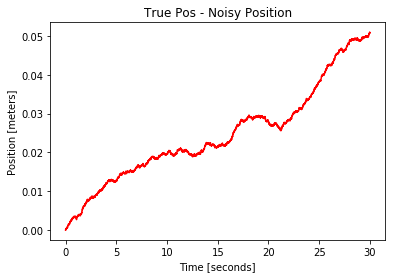

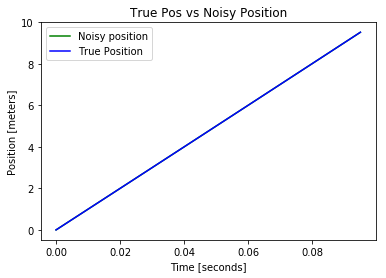

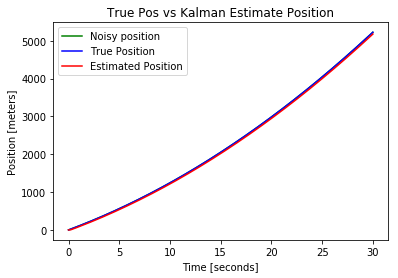

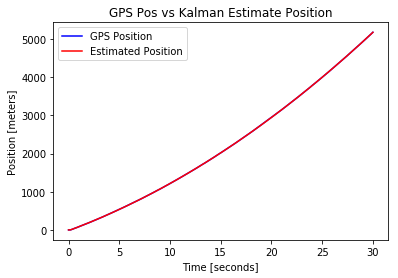

In [49]:
plt.figure(6)
plt.title('True Pos - Noisy Position')
plt.ylabel('Position [meters]')
plt.xlabel('Time [seconds]')
k = np.abs(np.array(Accelerometer_Pos) - np.array(True_Pos))
plt.plot(t1,k,'r')

# tp1, = plt.plot(t1[2:4],all_state_info['Accelerometer Pos'][2:4],'g', label = 'Noisy position')
# tp, = plt.plot(t1[2:4],True_Pos[2:4],'b', label = 'True Position')
# plt.legend(handles = [tp1, tp])



plt.figure(7)
plt.title('True Pos vs Noisy Position')
plt.ylabel('Position [meters]')
plt.xlabel('Time [seconds]')
tp1, = plt.plot(t1[0:20],Accelerometer_Pos[0:20],'g', label = 'Noisy position')
tp, = plt.plot(t1[0:20],True_Pos[0:20],'b', label = 'True Position')
plt.legend(handles = [tp1, tp])

plt.figure(8)
plt.title('True Pos vs Kalman Estimate Position')
plt.ylabel('Position [meters]')
plt.xlabel('Time [seconds]')
tp1, = plt.plot(t1,Accelerometer_Pos,'g', label = 'Noisy position')
tp, = plt.plot(t1,True_Pos,'b', label = 'True Position')
ep, = plt.plot(t2,Kalman_Estimate_Pos,'r', label = 'Estimated Position')
plt.legend(handles = [tp1, tp,ep])

plt.figure(9)
plt.title('GPS Pos vs Kalman Estimate Position')
plt.ylabel('Position [meters]')
plt.xlabel('Time [seconds]')
tp, = plt.plot(t2,GPS_Pos,'b', label = 'GPS Position')
ep, = plt.plot(t2,Kalman_Estimate_Pos,'r', label = 'Estimated Position')
plt.legend(handles = [ tp,ep])


[0, 1.5904568045740075, 19.476319300246992]
[0.0, 1.5796609308940286, 20.585458689789952]
[0, 0.5000513796745976, 1.000205290179474, 1.5004257011850988, 2.0006950857270307, 2.5010344590946296, 3.001519205786339, 3.502217925241872, 4.003107461545482, 4.504147979301195, 5.00536267486468, 5.5067114320849715, 6.008187274890232, 6.509832827056909, 7.011612145605675, 7.513497519131388, 8.015515567538877, 8.517693893889785, 9.019949746401009, 9.52223557896969, 10.024619554628554, 10.527153570209666, 11.029852789583746, 11.532731629313856, 12.035771331515802, 12.538907828725161, 13.042171110904482, 13.545539528320335, 14.04899263664462, 14.552598337358425, 15.05628217660314, 15.560038094446883, 16.063864666215302, 16.56780078780722, 17.071961238147477, 17.576268169848145, 18.08067671922465, 18.585171192856368, 19.089691883336837, 19.594305802411526, 20.099066276907564, 20.60395387104671, 21.108984959744667, 21.614181886177622, 22.11948631586602, 22.62490416137929, 23.130503814303424, 23.636306

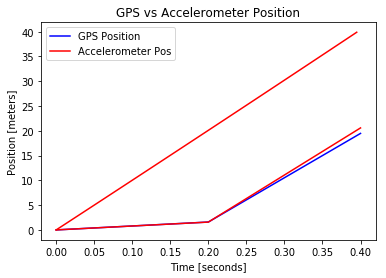

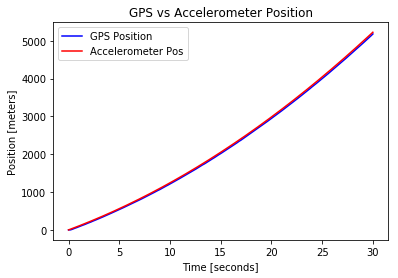

In [43]:
plt.figure(10)
plt.title('GPS vs Accelerometer Position')
plt.ylabel('Position [meters]')
plt.xlabel('Time [seconds]')
gpsp, = plt.plot(t2[0:3], GPS_Pos[0:3],'b', label = 'GPS Position')
accp, = plt.plot(t1[0:80], Accelerometer_Pos[0:80], 'r', label = 'Accelerometer Pos')
ep, = plt.plot(t2[0:3],Kalman_Estimate_Pos[0:3],'r', label = 'Estimated Position')

plt.legend(handles = [gpsp,accp])

plt.figure(11)
plt.title('GPS vs Accelerometer Position')
plt.ylabel('Position [meters]')
plt.xlabel('Time [seconds]')
gpsp, = plt.plot(t2, GPS_Pos,'b', label = 'GPS Position')
accp, = plt.plot(t1, Accelerometer_Pos, 'r', label = 'Accelerometer Pos')
# ep, = plt.plot(t2, Kalman_Estimate_Pos,'r', label = 'Estimated Position')
plt.legend(handles = [gpsp,accp])


# print(GPS_Pos[0])
# print(all_state_info['Accelerometer Pos'][0])
# print(t1[0:80])
# print(t2[0:3])
print(GPS_Pos[0:3])
print(Kalman_Estimate_Pos[0:3])
print(Accelerometer_Pos[0:80])


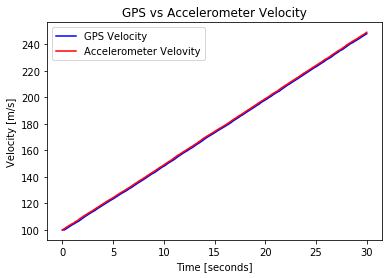

In [44]:
plt.figure(12)
plt.title('GPS vs Accelerometer Velocity')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Time [seconds]')
gv, = plt.plot(t2, GPS_Vel, 'b', label = 'GPS Velocity')
av, = plt.plot(t1, Accelerometer_Vel, 'r', label = 'Accelerometer Velovity')
plt.legend(handles = [gv,av])

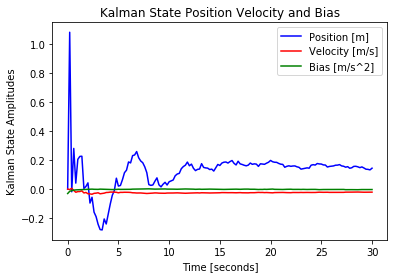

In [45]:
plt.figure(12)
plt.title('Kalman State Position Velocity and Bias')
plt.ylabel('Kalman State Amplitudes')
plt.xlabel('Time [seconds]')
ksp, = plt.plot(t2,Kalman_State_Pos,'b', label = 'Position [m]')
ksv, = plt.plot(t2,Kalman_State_Vel,'r', label = 'Velocity [m/s]')
ksb, = plt.plot(t2,Kalman_State_Bias,'g', label = 'Bias [m/s^2]')
plt.legend(handles =[ksp,ksv,ksb])

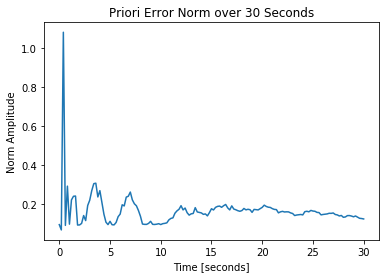

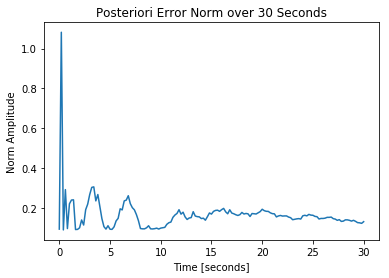

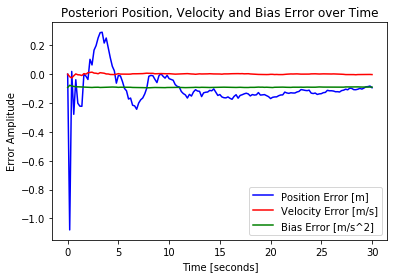

In [46]:



# Error Plotting
ax = plt.figure(9)
plt.title('Priori Error Norm over 30 Seconds')
plt.ylabel('Norm Amplitude')
plt.xlabel('Time [seconds]')
enorm = [np.linalg.norm(en) for en in Error_Priori]
plt.plot(t2,enorm, label = 'Norm')

plt.figure(10)
plt.ylabel('Norm Amplitude')
plt.xlabel('Time [seconds]')
plt.title('Posteriori Error Norm over 30 Seconds')
enorm = [np.linalg.norm(en) for en in Error_Posteriori]
plt.plot(t2,enorm)
#plt.figure(11)
#plt.title('Posteriori Position Error over Time')
epos = [np.asscalar(ex[0]) for ex in Error_Posteriori]
#plt.plot(t2,epos)
#plt.figure(12)
#plt.title('Posteriori Velocity Error over Time')
evel = [np.asscalar(evel[1]) for evel in Error_Posteriori]
#plt.plot(t2,evel)
eb = [np.asscalar(eb[2]) for eb in Error_Posteriori]

plt.figure(11)
plt.title('Posteriori Position, Velocity and Bias Error over Time')
plt.ylabel('Error Amplitude')
plt.xlabel('Time [seconds]')
pe, = plt.plot(t2,epos,'b', label = 'Position Error [m]')
ve, = plt.plot(t2,evel,'r',label = 'Velocity Error [m/s]')
be, = plt.plot(t2,eb,'g',label = 'Bias Error [m/s^2]')
plt.legend(handles = [pe,ve,be])
# plt.figure(14)
# plt.title('Priori Position Error over Time')
# epos = [np.asscalar(epos[0]) for epos in all_state_info['Error Priori']]
# plt.plot(t2,epos)
# plt.figure(15)
# plt.title('Priori Velocity Error over Time')
# evel = [np.asscalar(evel[1]) for evel in all_state_info['Error Priori']]
# plt.plot(t2,evel)
# plt.figure(16)
# plt.title('Priori Bias Error over Time')
# eb = [np.asscalar(eb[2]) for eb in all_state_info['Error Priori']]
# plt.plot(t2,eb)





# plt.figure(12)
# plt.title('True Vel')
# plt.ylabel('Velocity [m/s]')
# plt.xlabel('Time [seconds]')
# plt.plot(t1,all_state_info['True Vel'],'g')

# plt.figure(13)
# plt.title('True Pos')
# plt.ylabel('Position [m]')
# plt.xlabel('Time [seconds]')
# plt.plot(t1,True_Pos,'g')